In [2]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random

In [3]:
track_id2student_id_it = {7:0, 6:1, 0:2, 8:3, 1:4, 3:5, 11:6, 15:7, 16:8, 2:9, 5:12, 9:13, 4:14} # irimi tenkan, my tracking algo
track_id2student_id_ta = {8:0, 7:1, 2:2, 10:3, 3:4, 4:5, 14:6, 9:7, 1:8, 12:9, 11:10, 0:11, 6:12, 5:13} # tsugi ashi, my tracking algo
track_id2student_id_utmt = {7:0, 6:1, 1:2, 8:3, 3:4, 5:5, 11:6, 10:7, 2:8, 0:11, 4:13, 9:9, 12:10, 19:12} # utmt, my tracking algo
single_student_tids = {"1156":0, "1237":1, "0756":0, "0912":0, "1043":0}
file2mapping = {"../alphapose_res/irimi_tenkan_kps.json":track_id2student_id_it,
                "../alphapose_res/ta_tracking.json":track_id2student_id_ta,
                "../alphapose_res/utmt_kps.json":track_id2student_id_utmt}
annotations_map = {"../alphapose_res/irimi_tenkan_kps.json":"../data/irimi_tenkan/annotations.json",
                "../alphapose_res/ta_tracking.json":"../data/tsugi_ashi/annotations.json",
                "../alphapose_res/utmt_kps.json":"../data/ushiro_tenkan_mae_tenkan/annotations.json"}
single_st_ann = "../data/single_student_annotations.json"

In [193]:
SAMPLE_MAX_FRAME_COUNT = 192 # ?
THRESHOLD = 0.5
CHANNELS = 3
BATCH_FIRST = False
SEED = 42

# Подготовка данных

In [5]:
from dataproc import *

Собрать всё в массивы

1. Аннотации видео с толпой

In [6]:
exercise2points = dict()
exercise2errors = dict()
encoded_errors = {"нет ошибок":0}
for filename in file2mapping:
    sid2kps = parse_crowd_exercise(filename, file2mapping[filename])    
    with open(annotations_map[filename], "r", encoding="utf8") as ja:
        ann = json.load(ja)
        for k in ann:
            people = list(ann[k].keys())
            for personid in people:
                intkey = int(personid)
                ann[k][intkey] = ann[k][personid]            
    exname = os.path.basename(filename).split('.')[0]
    student_tries = split_student_tries(sid2kps, ann['people_exercise_frames'])
    errs = get_error_codes(ann, encoded_errors)
    exercise2points[exname] = student_tries
    exercise2errors[exname] = errs        

2. Аннотации видео одного ученика

In [7]:
student2points = dict()
#student2errors = dict()
with open(single_st_ann, "r", encoding="utf8") as common_ann_file:
    common_ann = json.load(common_ann_file)
ss_vid_ann = [os.path.join("../alphapose_res", f) for f in ["0756_alpha.json", "0912_alpha.json",
                                                           "1043_alpha.json", "1156_alpha.json", 
                                                            "1237_alpha.json"]]
for filename in ss_vid_ann:
    stud_id = os.path.split(filename)[-1][:4]
    dynamic = parse_single_person_exercise(filename, single_student_tids[stud_id])
    internal_vid_id = common_ann["file2id"][stud_id]
    student_tries = split_student_tries({internal_vid_id:dynamic}, common_ann['people_exercise_frames'])
    student2points[internal_vid_id] = student_tries[internal_vid_id]
student2errors = get_error_codes(common_ann, encoded_errors)

In [8]:
delete_keys = []
for ename in exercise2errors:
    for k in exercise2errors[ename]:
        if type(k) == str:
            delete_keys.append(k)
    for k in delete_keys:
        del exercise2errors[ename][k]
    delete_keys.clear()    

In [9]:
idx2error = dict()
for n in encoded_errors:
    idx = encoded_errors[n]
    idx2error[idx] = n

In [10]:
exercise2points["single_student"] = student2points
exercise2errors["single_student"] = student2errors

Dataset

In [67]:
def encode_label(label:list, class_count:int):
    target = np.zeros(class_count)
    for idx in label:
      target[idx] = 1
    return target
    
def decode_target(target, classes:dict, threshold:float=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(classes[i])
    return result

In [86]:
class AutoEvalLSTMDataset(Dataset):
    def __init__(self, images:list, labels:list, class_mapping:dict, frame_length:int, channel_count:int, batch_first=False):
        self.images = images
        self.labels = labels
        self.idx2class = class_mapping
        self.frame_len = frame_length
        self.channels = channel_count
        self.batch_first = batch_first
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        target = encode_label(label, max(self.idx2class) + 1)
        fixed_length_exerc = resample_to_frame_length(img, self.frame_len) 
        fixed_length_exerc = fixed_length_exerc[:, :, :self.channels]
        # fixed_length_exerc.shape = (n joints, self.frame_len, self.channels)        
        # flatten channels
        if self.batch_first:
            inp = fixed_length_exerc.reshape(self.frame_len, -1).astype('float32')
        else:
            inp = fixed_length_exerc.reshape(self.frame_len, 1, -1).astype('float32')
        return inp, target.astype('float32')

def batch_second_collate(batch):
    #print(batch[0])
    data = []
    labels = []
    for i, t in batch:
        data.append(torch.tensor(i))
        labels.append(torch.tensor(t))
    #data, labels = zip(*batch)
    stacked_data = torch.cat(data, 1)
    stacked_labels = torch.stack(labels)
    return stacked_data, stacked_labels

Splits

In [13]:
def fraction_split(exercise2points:dict, exercise2errors:dict, train_frac:float, val_frac:float, test_frac:float):
    assert (train_frac + val_frac + test_frac) == 1
    train_imgs, train_labels = [], []
    test_imgs, test_labels = [], []
    val_imgs, val_labels = [], []
    
    train_ids = []
    val_ids = []
    test_ids = []
    total_data_count = 0
    for exname in exercise2points:
        cur_exerc = exercise2points[exname]
        cur_errors = exercise2errors[exname]
        for p in cur_exerc:
            tries = cur_exerc[p]
            errs = cur_errors[p]
            for i, e in enumerate(tries):
                total_data_count += 1
                rval = random.random()
                if rval <= train_frac:
                    train_imgs.append(e)
                    train_labels.append(errs[i])
                    train_ids.append((exname, p, i))
                elif rval <= (train_frac + test_frac):
                    test_imgs.append(e)
                    test_labels.append(errs[i])
                    test_ids.append((exname, p, i))
                else:
                    val_imgs.append(e)
                    val_labels.append(errs[i])
                    val_ids.append((exname, p, i))
    return [(train_imgs, train_labels), (test_imgs, test_labels), (val_imgs, val_labels)]

def pick_elems_on_indices_from_both(data, labels, indices):
    X = []
    y = []
    for i in indices:
        X.append(data[i])
        y.append(labels[i])
    return X, y

def stratify_split(exercise2points:dict, exercise2errors:dict, train_frac:float, val_frac:float, test_frac:float, class_count:int, state=0):    
    input_data = []
    labels = []
    total_count = 0
    class2idx = dict()
    for exname in exercise2points:
        cur_exerc = exercise2points[exname]
        cur_errors = exercise2errors[exname]
        for p in cur_exerc:
            tries = cur_exerc[p]
            errs = cur_errors[p]
            for i, e in enumerate(tries):
                input_data.append(e)
                labels.append(errs[i])
                #labels.append(encode_label(errs[i], class_count).numpy())
                for error in errs[i]:
                    if error not in class2idx:
                        class2idx[error] = []
                    class2idx[error].append(total_count)
                total_count += 1
    random.seed(state)
    train_instances_idx = set()
    val_instances_idx = set()
    test_instances_idx = set()
    for cl in class2idx:
        class_indices = class2idx[cl]
        random.shuffle(class_indices)
        last_train_idx = max(int(train_frac * len(class_indices)), 1)
        train_picks = class_indices[:last_train_idx]
        train_instances_idx.update(train_picks)
        if (len(class_indices) - len(train_picks)) == 0:
            continue
        last_test_idx = last_train_idx + max(int(test_frac * len(class_indices)), 1)
        test_picks = class_indices[last_train_idx:last_test_idx]
        test_instances_idx.update(test_picks)
        if (len(class_indices) - len(train_picks) - len(test_picks)) == 0:
            continue
        val_instances_idx.update(class_indices[last_test_idx:])
    # clear repeating values
    val_instances_idx = val_instances_idx - val_instances_idx.intersection(train_instances_idx)
    test_instances_idx = test_instances_idx - test_instances_idx.intersection(train_instances_idx)
    
    X_train, y_train = pick_elems_on_indices_from_both(input_data, labels, train_instances_idx)  
    X_test, y_test = pick_elems_on_indices_from_both(input_data, labels, test_instances_idx)
    X_val, y_val = pick_elems_on_indices_from_both(input_data, labels, val_instances_idx)
    
    # train_count = round(total_count * train_frac)
    # val_count = round(total_count * val_frac)
    # test_count = round(total_count * test_frac)
    # "The minimum number of groups for any class cannot be less than 2" для sklearn.model_selection.train_test_split
    # X_train, X_test, y_train, y_test = train_test_split(input_data, 
    #                                                     train_size=train_count+val_count, 
    #                                                     random_state=state, stratify=labels)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, 
    #                                                   train_size=train_count, 
    #                                                   random_state=state, stratify=y_train)
    return [(X_train, y_train), (X_test, y_test), (X_val, y_val)]
                

In [14]:
random.seed(SEED)
# dividing
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

#train_data, test_data, val_data = fraction_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac)
train_data, test_data, val_data = stratify_split(exercise2points, exercise2errors, train_frac, val_frac, test_frac, SEED)
train_imgs, train_labels = train_data
test_imgs, test_labels = test_data
val_imgs, val_labels = val_data
total_data_count = len(train_imgs) + len(test_imgs) + len(val_imgs)

print("Total", total_data_count)
print("Train count", len(train_imgs))
print("Test count", len(test_imgs))
print("Val count", len(val_imgs))

Total 298
Train count 210
Test count 54
Val count 34


In [87]:
#frame_length:int, channel_count:int, batch_first=False
train_ds = AutoEvalLSTMDataset(train_imgs, train_labels, idx2error, SAMPLE_MAX_FRAME_COUNT, CHANNELS, BATCH_FIRST)
val_ds = AutoEvalLSTMDataset(val_imgs, val_labels, idx2error, SAMPLE_MAX_FRAME_COUNT, CHANNELS, BATCH_FIRST)
test_ds = AutoEvalLSTMDataset(test_imgs, test_labels, idx2error, SAMPLE_MAX_FRAME_COUNT, CHANNELS, BATCH_FIRST)

In [89]:
batch_size = 32
if BATCH_FIRST:
    collate_func = torch.utils.data.default_collate
else:
    collate_func = batch_second_collate
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_func)
val_loader = DataLoader(val_ds, batch_size, collate_fn=collate_func)
test_loader = DataLoader(test_ds, 1, shuffle=False, collate_fn=collate_func)

# Training

Model

In [109]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, num_classes:int, input_dim:int, batch_first:bool, hidden_size:int=100, layers:int=5):
        super().__init__()
        # try 5? lstm layers
        #hidden size?
        self.feature_extractor = torch.nn.LSTM(input_dim, hidden_size, num_layers=layers, batch_first=batch_first)
        self.cls = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, num_classes),
            torch.nn.Sigmoid()
        )
        
    def forward(self, xb):
        #xb.shape = (seq, batch, feat) or (batch, seq, feat)
        out, hidden_t = self.feature_extractor(xb)
        hidden = hidden_t[0]
        cls_input = hidden[-1,:]#.flatten()
        return self.cls(cls_input)

Train Functions

In [110]:
def F_score(output, label, threshold=0.5, beta=1): #Calculate the accuracy of the model
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
        
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

cuda


In [111]:
def train_one_epoch(model:torch.nn.Module, criterion, optimizer, data_loader:DeviceDataLoader):
    model.train()
    running_losses = []
    for i, (image, target) in enumerate(data_loader):        
        optimizer.zero_grad()
        out = model(image)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step() 
        running_losses.append(loss)
    return torch.stack(running_losses).mean().item()
    
def evaluate(model, val_data_loader:DeviceDataLoader, criterion=F.binary_cross_entropy):
    model.eval() 
    running_losses = []
    running_fscore = []
    with torch.no_grad():
        for i, (image, target) in enumerate(val_data_loader):
            out = model(image)
            loss = criterion(out, target)
            running_losses.append(loss.detach())
            running_fscore.append(F_score(out, target).detach())
    l = torch.stack(running_losses).mean().item()
    fs = torch.stack(running_fscore).mean().item()
    return l, fs

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, criterion=F.binary_cross_entropy):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        train_loss = train_one_epoch(model, criterion, optimizer, train_loader)
        # Validation phase
        val_loss, val_score = evaluate(model, val_loader, criterion)
        result = {'train_loss':train_loss, 'val_loss':val_loss, 'val_score':val_score}
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))
        history.append(result)
    return history

In [112]:
#checking the shape of outputs that the model will produce before starting the training process
model = to_device(RNNClassifier(len(idx2error), 26*CHANNELS, BATCH_FIRST), device)
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
history = [evaluate(model, val_dl)]
print(history)

torch.Size([192, 32, 78])
outputs.shape :  torch.Size([32, 23])
Sample outputs :
 tensor([[0.5085, 0.4735, 0.4958, 0.5091, 0.5120, 0.4944, 0.4903, 0.4871, 0.4756,
         0.4837, 0.5106, 0.4986, 0.5048, 0.4987, 0.5165, 0.4872, 0.4844, 0.4787,
         0.5105, 0.5139, 0.5113, 0.4951, 0.5215],
        [0.5085, 0.4735, 0.4959, 0.5091, 0.5119, 0.4943, 0.4903, 0.4872, 0.4757,
         0.4836, 0.5108, 0.4986, 0.5048, 0.4986, 0.5165, 0.4873, 0.4842, 0.4787,
         0.5106, 0.5138, 0.5113, 0.4950, 0.5215]], device='cuda:0')
[(0.6892766952514648, 0.1618002951145172)]


Само обучение

In [180]:
model = to_device(RNNClassifier(len(idx2error), 26*CHANNELS, BATCH_FIRST, hidden_size=10, layers=1), device)
epochs = 100
lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit(epochs, lr, model, train_dl, val_dl, opt_func=opt_func)

Showing results

In [115]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Validation F1 score vs. No. of epochs');
    
def plot_losses(history, loss_name):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title(f'{loss_name} Loss vs. No. of epochs');

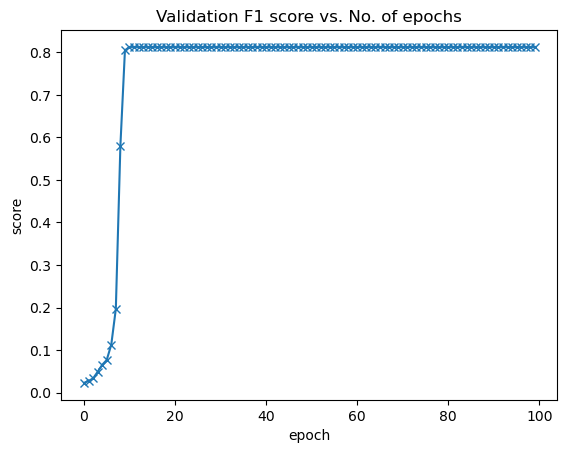

In [182]:
plot_scores(history)

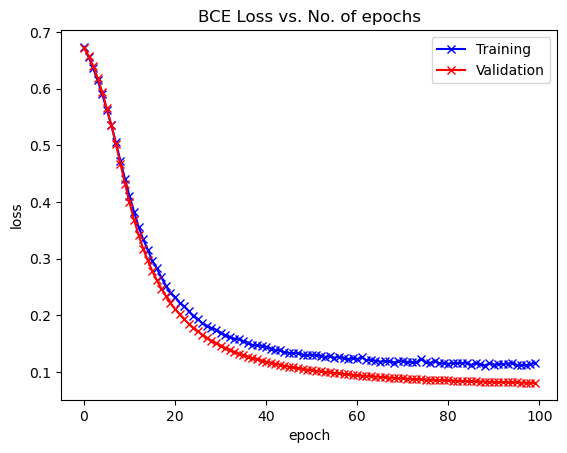

In [183]:
plot_losses(history, "BCE")

# Metrics

https://stats.stackexchange.com/questions/12702/what-are-the-measure-for-accuracy-of-multilabel-data

In [118]:
def exact_match_ratio(y_pred:np.ndarray, y_true:np.ndarray)->float:
    samples_count = y_pred.shape[0]
    return (y_true == y_pred).all(1).astype(np.float32).sum() / samples_count

def multilabel_accuracy(y_pred:np.ndarray, y_true:np.ndarray)->float: # пока равна recall
    samples_count = y_pred.shape[0]
    # intersection over union of classes
    accuracy_sum = 0.0
    for sample in range(samples_count):
        pred_sample = y_pred[sample, :]
        true_sample = y_true[sample, :]
        pred_classes = set(decode_target(pred_sample, idx2error))
        true_classes = set(decode_target(true_sample, idx2error))
        accuracy_sum += float(len(pred_classes&true_classes))/len(pred_classes|true_classes)
    return accuracy_sum / samples_count

def hamming_loss(y_pred:np.ndarray, y_true:np.ndarray)->float:
    hl_sum = (1 - y_pred[np.nonzero(y_true)]).sum()
    hl_sum += y_pred[y_true == 0].sum()
    return hl_sum / y_pred.size

# Testing

In [119]:
def show_example(img, pred_label, true_label=None):
    plt.imshow(img.permute(1,2,0))
    print("Predicted label:", decode_target(pred_label, idx2error))
    if true_label != None:
        print("True label:", decode_target(true_label, idx2error))
    print()
    print(pred_label)

def predict_single(image, label=None):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction, label)

In [184]:
model.eval()
test_dl = DeviceDataLoader(test_loader, device)

test_losses = []
test_f1s = []
preds = []
trues = []
with torch.no_grad():
    for batch in test_dl:
        images, targets = batch 
        out = model(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        score = F_score(out, targets)                 # Calculate accuracy
        test_losses.append(loss.detach().cpu().item())
        test_f1s.append(score.detach().cpu().item())
        preds.append(out.cpu().numpy())
        trues.append(targets.cpu().numpy())

In [185]:
preds_labels = []
for pred in preds:
    preds_labels.append((pred > THRESHOLD).astype(np.float32))
pred_ar = np.array(preds_labels).squeeze()
trues_ar = np.array(trues).squeeze()

In [186]:
zeros_fraction = (trues_ar == 0).astype(np.float32).sum() / trues_ar.size
print("Zeros in data:", zeros_fraction)

Zeros in data: 0.9541062801932367


In [187]:
# test_loss = np.mean(test_losses)
# testf1 = np.mean(test_f1s)
print("Test BCE loss:", np.mean(test_losses))
print("Test F1-score:", np.mean(test_f1s))

Test BCE loss: 0.09440668403274483
Test F1-score: 0.7592592592592593


In [188]:
# exact match ratio
#emr = (trues_ar == pred_ar).astype(np.float32).sum() / trues_ar.size
emr = exact_match_ratio(pred_ar, trues_ar)
print("Exact match ratio:", emr)

Exact match ratio: 0.7592592592592593


In [189]:
print("Hamming loss:", hamming_loss(pred_ar, trues_ar)) # less is better

Hamming loss: 0.023349436392914653


In [190]:
print("Accuracy:", multilabel_accuracy(pred_ar, trues_ar))

Accuracy: 0.7592592592592593


In [191]:
print(classification_report(trues_ar, pred_ar, target_names=np.array([idx2error[i] for i in range(len(idx2error))]), zero_division=0))

                                                 precision    recall  f1-score   support

                                     нет ошибок       0.76      1.00      0.86        41
                                 наклон корпуса       0.00      0.00      0.00         3
                                короткая стойка       0.00      0.00      0.00         1
                                  вес на задней       0.00      0.00      0.00         2
                             касание, нет упора       0.00      0.00      0.00         2
                                  подтаскивание       0.00      0.00      0.00         1
                                стопа в воздухе       0.00      0.00      0.00         1
                        стопы не доворачиваются       0.00      0.00      0.00         1
                                 повышение таза       0.00      0.00      0.00         0
                        стопы направлены внутрь       0.00      0.00      0.00         1
                    

In [192]:
# всегда предсказывает "нет ошибок" (индекс 0)
pred_ar[:, 1:].nonzero()

(array([], dtype=int64), array([], dtype=int64))